# Final Project

### Nicholai L'Esperance

#### imports

In [148]:
import json
import pandas as pd
from functools import reduce
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from collections import Counter
from itertools import product
import seaborn as sns

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

pd.set_option('display.max_columns', 200)

In [2]:
state_map = {'Alaska': 'AK', 'Alabama': 'AL', 'Arkansas': 'AR', 'American Samoa': 'AS', 'Arizona': 'AZ', 'California': 'CA', 'Colorado': 'CO', 
             'Connecticut': 'CT', 'District of Columbia': 'DC', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Guam': 'GU', 'Hawaii': 'HI', 
             'Iowa': 'IA', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Massachusetts': 'MA', 
             'Maryland': 'MD', 'Maine': 'ME', 'Michigan': 'MI', 'Minnesota': 'MN', 'Missouri': 'MO', 'Northern Mariana Islands': 'MP', 'Mississippi': 'MS', 
             'Montana': 'MT', 'National': 'NA', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Nebraska': 'NE', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 
             'New Mexico': 'NM', 'Nevada': 'NV', 'New York': 'NY', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 
             'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Virginia': 'VA', 
             'Virgin Islands': 'VI', 'Vermont': 'VT', 'Washington': 'WA', 'Wisconsin': 'WI', 'West Virginia': 'WV', 'Wyoming': 'WY'}

## Load Yelp Data
#### Source: https://www.yelp.com/dataset/download

In [3]:
yelp_data_filename = 'yelp_academic_dataset_business.json'

with open(yelp_data_filename, 'r') as fin:
    yelp_data_list = [json.loads(line) for line in fin]
    
raw_yelp_data = pd.DataFrame(yelp_data_list)
raw_yelp_data['categories'] = raw_yelp_data['categories'].str.lower()
print(raw_yelp_data.shape)

(209393, 14)


### Pull out only restaurants, and filter/create category features

In [4]:
food_words = ('food', 'restaurant', 'bar')

is_food = reduce(np.logical_or, [raw_yelp_data['categories'].str.contains(food_word) for food_word in food_words]).fillna(False)

yelp_food = raw_yelp_data.loc[is_food & raw_yelp_data.state.isin(state_map.values())]

print(f'I found {len(yelp_food)} establishments that serve food.')

I found 52930 establishments that serve food.


We need to break the categories out, and only keep some number of the most common. Then, we can convert to dummies.

In [5]:
cat_count = Counter()
for catsplit in yelp_food['categories'].str.split(','):
    if catsplit is not None:
        cat_count.update(map(str.strip, catsplit))

ignore_categories = ('restaurants', 'food')
n_keep = 150
keep_categories = [tup[0] for tup in cat_count.most_common() if tup[0] not in ignore_categories][:n_keep]

def filter_cats(categories: list):
    if categories is None:
        return list()
    return [category for category in map(str.strip, categories) if category in keep_categories and category not in ignore_categories]

filtered_categories = [filter_cats(category_list) for category_list in yelp_food['categories'].str.split(',')]
cat_rows = [{cat: 1 for cat in cat_list} for cat_list in filtered_categories]

category_dummies = pd.DataFrame(cat_rows).fillna(0)
category_dummies.columns = category_dummies.columns.str.lower().str.replace(' ', '_')

How many of our rows do not have *any* category labels?

In [268]:
cat_count.most_common()[:30]

[('restaurants', 38245),
 ('food', 20882),
 ('nightlife', 8755),
 ('bars', 8430),
 ('american (traditional)', 6236),
 ('fast food', 5934),
 ('sandwiches', 5808),
 ('pizza', 4985),
 ('coffee & tea', 4686),
 ('american (new)', 4507),
 ('mexican', 4483),
 ('burgers', 4263),
 ('breakfast & brunch', 3910),
 ('italian', 3031),
 ('specialty food', 2974),
 ('shopping', 2894),
 ('event planning & services', 2714),
 ('grocery', 2641),
 ('desserts', 2338),
 ('chinese', 2334),
 ('beauty & spas', 2268),
 ('salad', 2258),
 ('bakeries', 2232),
 ('ice cream & frozen yogurt', 2194),
 ('chicken wings', 2111),
 ('convenience stores', 1897),
 ('sports bars', 1857),
 ('seafood', 1848),
 ('beer', 1796),
 ('wine & spirits', 1796)]

In [7]:
category_dummies.sum(axis=1).eq(0).sum()

405

### Parse the Yelp Attributes, create Attribute features

In [8]:
attribute_list_of_dicts = [data['attributes'] for data, food in zip(yelp_data_list, is_food) if food]

attribute_counter = Counter()
for attribute_dict in attribute_list_of_dicts:
    if attribute_dict is not None:
        attribute_counter.update(attribute_dict.keys())

attribute_counter.most_common()[:10]

[('RestaurantsPriceRange2', 72456),
 ('BusinessParking', 72277),
 ('RestaurantsTakeOut', 65991),
 ('OutdoorSeating', 57275),
 ('RestaurantsDelivery', 55655),
 ('BikeParking', 55478),
 ('RestaurantsGoodForGroups', 55249),
 ('RestaurantsReservations', 55053),
 ('GoodForKids', 54573),
 ('Ambience', 53062)]

In [9]:
keep_attributes = ['RestaurantsAttire',
                   'RestaurantsTakeOut',
                   'BusinessAcceptsCreditCards',
                   'NoiseLevel',
                   'RestaurantsReservations',
                   'RestaurantsGoodForGroups',
                   'RestaurantsPriceRange2',
                   'HasTV',
                   'Alcohol',
                   'RestaurantsDelivery']

att_rows = [{key: val for key, val in attribute_dict.items() if key in keep_attributes} if isinstance(attribute_dict, dict) else dict() 
            for attribute_dict in attribute_list_of_dicts]

In [10]:
att_frame = pd.DataFrame(att_rows)
att_frame.head()

,RestaurantsAttire,RestaurantsTakeOut,BusinessAcceptsCreditCards,NoiseLevel,RestaurantsReservations,RestaurantsGoodForGroups,RestaurantsPriceRange2,HasTV,Alcohol,RestaurantsDelivery
0,u'casual',True,True,u'quiet',False,False,1,True,'none',True
1,NaN,True,True,NaN,NaN,NaN,1,NaN,NaN,NaN
2,u'casual',True,True,NaN,False,True,1,NaN,NaN,NaN
3,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,True,NaN,NaN,False,NaN,NaN,True,u'none',True


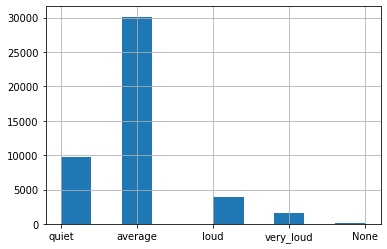

In [11]:
att_frame['NoiseLevel'].str.strip("u'").hist()

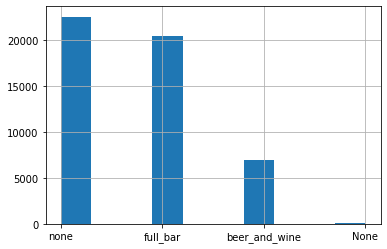

In [12]:
att_frame['Alcohol'].str.strip("u'").hist()

In [13]:
att_frame = pd.DataFrame(att_rows)
att_frame.head()

dress_map = {'None': 0, 
             'casual': 0, 
             'formal': 1, 
             'dressy': 1}

noise_map = {'quiet': 0,
             'average': 1,
             'loud': 2,
             'very_loud': 3,
             'None': 1}

alcohol_map = {'none': 0,
               'None': 0,
               'beer_and_wine': 1,
               'full_bar': 2}

bool_map = {'True': 1, 'False': 0, 'None': 1}

att_frame['RestaurantsAttire'] = att_frame['RestaurantsAttire'].fillna('casual').str.strip("u'").map(dress_map)
att_frame['RestaurantsTakeOut'] = att_frame['RestaurantsTakeOut'].map(bool_map).fillna(1)
att_frame['BusinessAcceptsCreditCards'] = att_frame['BusinessAcceptsCreditCards'].map(bool_map).fillna(1)
att_frame['NoiseLevel'] = att_frame['NoiseLevel'].fillna('average').str.strip("u'").map(noise_map).fillna(1)
att_frame['RestaurantsReservations'] = att_frame['RestaurantsReservations'].map(bool_map).fillna(0.5)
att_frame['RestaurantsGoodForGroups'] = att_frame['RestaurantsGoodForGroups'].map(bool_map).fillna(0.5)
att_frame['RestaurantsPriceRange2'] = att_frame['RestaurantsPriceRange2'].replace('None', 2.5).fillna(2.5).astype(float)
att_frame['HasTV'] = att_frame['HasTV'].replace('None', 'False').map(bool_map).fillna(0)
att_frame['Alcohol'] = att_frame['Alcohol'].str.strip("u'").map(alcohol_map).fillna(1)
att_frame['RestaurantsDelivery'] = att_frame['RestaurantsDelivery'].fillna('None').replace('None', 'False').map(bool_map)

att_frame.columns = att_frame.columns.str.lower()

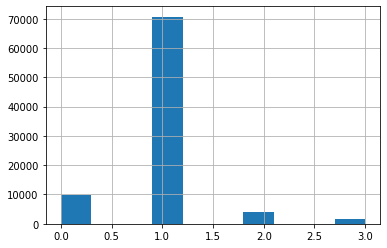

In [14]:
att_frame['noiselevel'].hist()

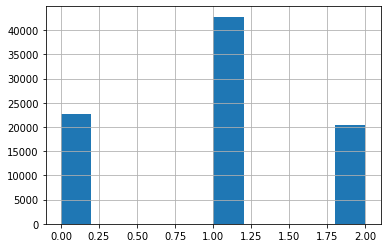

In [15]:
att_frame['alcohol'].hist()

In [16]:
yelp_final = yelp_food[['business_id', 'state', 'latitude', 'longitude', 'stars']].reset_index(drop=True).join(category_dummies).join(att_frame).set_index('business_id')
yelp_final.head(3)

,state,latitude,longitude,stars,ethnic_food,food_trucks,specialty_food,imported_food,desserts,ice_cream_&_frozen_yogurt,grocery,middle_eastern,hotels_&_travel,beer,wine_&_spirits,food_delivery_services,donuts,juice_bars_&_smoothies,coffee_&_tea,bakeries,fast_food,mexican,vietnamese,soup,burgers,american_(traditional),chicken_wings,american_(new),hot_dogs,chinese,bars,arts_&_entertainment,nightlife,music_venues,cafes,shopping,local_flavor,flowers_&_gifts,florists,pizza,lounges,breakfast_&_brunch,salad,beauty_&_spas,barbers,thai,sandwiches,pubs,gastropubs,fish_&_chips,seafood,street_vendors,cajun/creole,italian,dive_bars,comfort_food,filipino,tex-mex,health_markets,vitamins_&_supplements,health_&_medical,active_life,venues_&_event_spaces,event_planning_&_services,party_&_event_planning,education,caterers,diners,sushi_bars,cosmetics_&_beauty_supply,convenience_stores,photography_stores_&_services,drugstores,barbeque,southern,buffets,asian_fusion,japanese,vegetarian,ramen,vegan,chicken_shop,candy_stores,automotive,gas_stations,food_stands,fitness_&_instruction,barre_classes,mediterranean,halal,cocktail_bars,shaved_ice,bubble_tea,delis,indian,adult_entertainment,custom_cakes,coffee_roasteries,beer_bar,tapas_bars,tapas/small_plates,arcades,wine_bars,fruits_&_veggies,discount_store,gluten-free,sports_bars,hookah_bars,soul_food,wraps,home_&_garden,do-it-yourself_food,gelato,tacos,greek,korean,french,steakhouses,caribbean,hair_salons,department_stores,fashion,casinos,breweries,local_services,bagels,hair_stylists,meat_shops,farmers_market,noodles,hawaiian,tobacco_shops,men's_hair_salons,creperies,wineries,home_services,professional_services,hotels,international_grocery,gift_shops,dance_clubs,car_wash,acai_bowls,tea_rooms,cupcakes,cheesesteaks,pakistani,pool_halls,karaoke,latin_american,chocolatiers_&_shops,gay_bars,electronics,poke,restaurantsattire,restaurantstakeout,businessacceptscreditcards,noiselevel,restaurantsreservations,restaurantsgoodforgroups,restaurantspricerange2,hastv,alcohol,restaurantsdelivery
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
pQeaRpvuhoEqudo3uymHIQ,IL,40.110446,-88.233073,4.5,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0,0.0,0.0,1.0,1.0,0.0,1
M_guz7Dj7hX0evS672wIwA,WI,43.105310,-89.510142,3.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,1,0.5,0.5,1.0,0.0,1.0,0
CsLQLiRoafpJPJSkNX2h5Q,NC,35.194894,-80.767442,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [17]:
yelp_final.shape

(52930, 164)

## Cost of living data by state
#### source: https://worldpopulationreview.com/state-rankings/cost-of-living-index-by-state

In [19]:
cost_of_living = pd.read_csv('cost_of_living.csv')

cost_of_living.columns = cost_of_living.columns.str.lower()

In [20]:
cost_of_living.head()

,state,costindex,costrank,grocerycost,housingcost,utilitiescost,transportationcost,misccost
0,Mississippi,86.1,1,91.6,70.1,89.1,89.2,91.4
1,Arkansas,86.9,2,92.0,73.9,91.8,83.6,85.6
2,Oklahoma,87.0,3,95.4,71.9,94.1,89.5,93.2
3,Missouri,87.1,4,96.6,70.6,99.6,87.3,95.7
4,New Mexico,87.5,5,100.9,77.7,87.9,91.6,100.1


In [21]:
cost_of_living['state'] = cost_of_living['state'].map(state_map)

In [22]:
cost_of_living.head()

,state,costindex,costrank,grocerycost,housingcost,utilitiescost,transportationcost,misccost
0,MS,86.1,1,91.6,70.1,89.1,89.2,91.4
1,AR,86.9,2,92.0,73.9,91.8,83.6,85.6
2,OK,87.0,3,95.4,71.9,94.1,89.5,93.2
3,MO,87.1,4,96.6,70.6,99.6,87.3,95.7
4,NM,87.5,5,100.9,77.7,87.9,91.6,100.1


## Healthcare costs by state
#### source: https://www.kff.org/other/state-indicator/health-spending-per-capita

In [23]:
health_data = pd.read_csv('health_cost.csv')
health_data.columns = health_data.columns.str.lower()

health_data.head()

,location,health spending per capita
0,United States,"$8,045"
1,Alabama,"$7,281"
2,Alaska,"$11,064"
3,Arizona,"$6,452"
4,Arkansas,"$7,408"


In [24]:
health_data['location'] = health_data['location'].map(state_map)

health_data.columns = ('state', 'health_spending_per_capita')

health_data['health_spending_per_capita'] = health_data['health_spending_per_capita'].str.strip('$').str.replace(',', '').astype(int)

In [25]:
health_data.head()

,state,health_spending_per_capita
0,NaN,8045
1,AL,7281
2,AK,11064
3,AZ,6452
4,AR,7408


The NaNs don't matter, they'll get dropped with the merge.    

## Median Household Income by State
#### source: https://www.kff.org/other/state-indicator/median-annual-income

In [26]:
income_data = pd.read_csv('median_income.csv')
income_data.columns = income_data.columns.str.lower()

income_data['location'] = income_data['location'].map(state_map)
income_data = income_data.rename(columns={'location': 'state',
                                          'median annual household income': 'household_income'})

income_data['household_income'] = income_data['household_income'].str.strip('$').str.replace(',', '').astype(int)

income_data.head()

,state,household_income
0,NaN,60336
1,AL,48123
2,AK,73181
3,AZ,56581
4,AR,45869


## Crime by State
#### source: https://www.ucrdatatool.gov/Search/Crime/State/RunCrimeStatebyState.cfm
#### note: required significant post-processing to 'unify' the states

In [27]:
raw_crime_data = pd.read_csv("crime_data_state.csv")

raw_crime_data.columns = raw_crime_data.columns.str.lower()
raw_crime_data.head()

,state,year,population,violent_crime_total,murder_manslaughter,legacy_rape,revised_rape,robbery,aggravated_assault
0,Alabama,2012,4817528,21693,342,1296,NaN,5020,15035
1,Alabama,2013,4833996,20834,346,1449,2055.0,4645,13788
2,Alabama,2014,4849377,20727,276,1436,2005.0,4701,13745
3,Alaska,2012,4817528,21693,342,1296,NaN,5020,15035
4,Alaska,2013,4833996,20834,346,1449,2055.0,4645,13788


In [28]:
raw_crime_data['murder_per_capita'] = raw_crime_data['murder_manslaughter'] / raw_crime_data['population']
raw_crime_data['violent_per_capita'] = raw_crime_data['violent_crime_total'] / raw_crime_data['population']
raw_crime_data['rape_per_capita'] = raw_crime_data['revised_rape'] / raw_crime_data['population']
raw_crime_data['robbery_per_capita'] = raw_crime_data['robbery'] / raw_crime_data['population']
raw_crime_data['assault_per_capita'] = raw_crime_data['aggravated_assault'] / raw_crime_data['population']

In [29]:
def change(series):
    return series.iloc[-1] - series.iloc[-2]

cols = ['state', 'murder_per_capita', 'violent_per_capita', 'rape_per_capita', 'robbery_per_capita', 'assault_per_capita']
year_to_year_change = raw_crime_data[cols].groupby('state').agg(change)
year_to_year_change.columns = year_to_year_change.columns + '_change'
year_to_year_change = year_to_year_change.reset_index()

In [30]:
keep_cols = ['state', 'population', 'murder_per_capita', 'violent_per_capita', 'rape_per_capita', 'robbery_per_capita', 'assault_per_capita']

crime_data = raw_crime_data.loc[raw_crime_data.year.eq(2014), keep_cols].merge(year_to_year_change, on='state')
crime_data['state'] = crime_data['state'].map(state_map)

In [31]:
crime_data

,state,population,murder_per_capita,violent_per_capita,rape_per_capita,robbery_per_capita,assault_per_capita,murder_per_capita_change,violent_per_capita_change,rape_per_capita_change,robbery_per_capita_change,assault_per_capita_change
0,AL,4849377,0.000057,0.004274,0.000413,0.000969,0.002834,-1.466187e-05,-0.000036,-0.000012,8.500134e-06,-0.000018
1,AK,4849377,0.000057,0.004274,0.000413,0.000969,0.002834,-1.466187e-05,-0.000036,-0.000012,8.500134e-06,-0.000018
2,AZ,736732,0.000056,0.006358,0.001047,0.000854,0.004402,9.534408e-06,-0.000029,-0.000208,8.748536e-06,0.000160
3,AR,6731484,0.000047,0.003999,0.000502,0.000928,0.002521,-6.114916e-06,-0.000158,0.000023,-7.484121e-05,-0.000100
4,CA,2966369,0.000056,0.004801,0.000594,0.000691,0.003460,2.222900e-06,0.000169,0.000091,-7.308961e-05,0.000150
5,CO,38802500,0.000044,0.003961,0.000297,0.001255,0.002366,-1.645770e-06,-0.000065,0.000028,-1.411756e-04,0.000049
6,CT,5355866,0.000028,0.003091,0.000567,0.000567,0.001928,-4.810628e-06,0.000037,0.000005,-2.741572e-05,0.000064
7,DE,3596677,0.000024,0.002369,0.000217,0.000878,0.001250,-1.371446e-06,-0.000253,-0.000030,-1.082588e-04,-0.000113
8,DC,935614,0.000058,0.004891,0.000413,0.001356,0.003064,1.340328e-05,-0.000116,-0.000019,2.370136e-05,-0.000135
9,FL,658893,0.000159,0.012444,0.000716,0.005307,0.006261,6.796343e-07,-0.000520,0.000108,-9.812141e-04,0.000352


## Merge all the data together.

In [32]:
final = yelp_final.merge(cost_of_living, 
                         how='left', 
                         on='state').merge(health_data,
                                           how='left',
                                           on='state').merge(income_data,
                                                             how='left',
                                                             on='state').merge(crime_data,
                                                                               how='left',
                                                                               on='state')
final = final.drop(columns='state')
final.index = yelp_final.index

### Can we gleam information from simple correlations?

In [33]:
corr = final.corr()

Anything interesting with latitude and longitude?

In [34]:
corr.loc['latitude'].sort_values(ascending=False).head(7)

latitude                      1.000000
health_spending_per_capita    0.929867
longitude                     0.690183
rape_per_capita_change        0.468253
grocerycost                   0.269153
household_income              0.142046
misccost                      0.101818
Name: latitude, dtype: float64

In [35]:
corr.loc['longitude'].sort_values(ascending=False).head(7)

longitude                     1.000000
health_spending_per_capita    0.847532
latitude                      0.690183
rape_per_capita_change        0.558807
population                    0.481734
misccost                      0.066129
american_(traditional)        0.052420
Name: longitude, dtype: float64

Are there any strong food correlations to violent crime?

In [36]:
corr.loc['violent_per_capita_change'].sort_values(ascending=False).head(7)

violent_per_capita_change    1.000000
transportationcost           0.875085
housingcost                  0.824494
costindex                    0.790358
costrank                     0.699411
assault_per_capita_change    0.682676
grocerycost                  0.604094
Name: violent_per_capita_change, dtype: float64

There is no strong correlation to stars, so we will have to see how well our model does!

In [37]:
corr.loc['stars'].sort_values(ascending=False).head(7)

stars             1.000000
specialty_food    0.131166
desserts          0.112841
food_trucks       0.093622
barbers           0.093102
bakeries          0.089355
vegan             0.079964
Name: stars, dtype: float64

# Unsupervised Learning

We are going to take a different approach to our clustering. I am going to use PCA first as a tool to visualize potential clusters. Then, I will determine the number of clusters both visually and with the elbow method. From here, perhaps we can create a new, useful feature to aid our model.

In [38]:
scaled_final = StandardScaler().fit_transform(final)

pca_2d = PCA(n_components=2)
final_2d = pd.DataFrame(pca_2d.fit_transform(scaled_final), columns=['X', 'Y'])

pca_3d = PCA(n_components=3)
final_3d = pd.DataFrame(pca_3d.fit_transform(scaled_final), columns=['X', 'Y', 'Z'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/collections.py:886: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


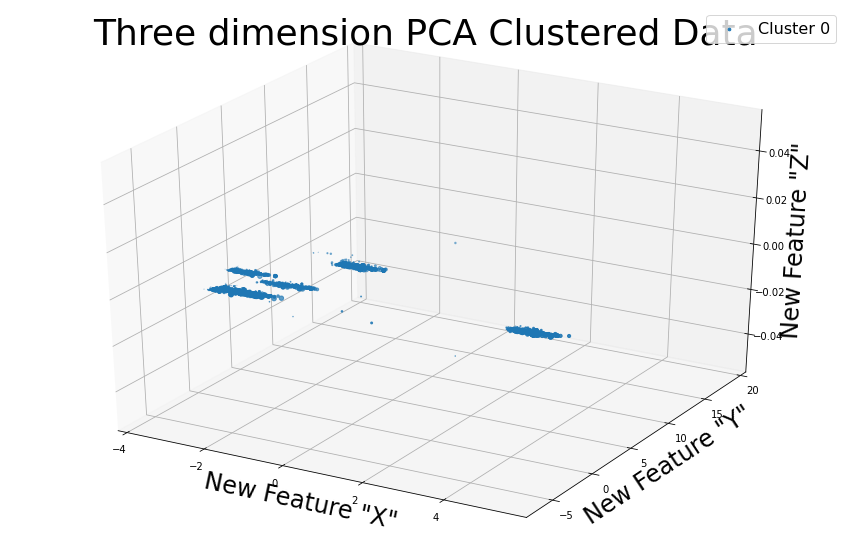

In [39]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(final_3d.X, final_3d.Y, final_3d.Z)
    
ax.set_title('Three dimension PCA Clustered Data', fontsize=36)
ax.set_xlabel('New Feature "X"', fontsize=24)
ax.set_ylabel('New Feature "Y"', fontsize=24)
ax.set_zlabel('New Feature "Z"', fontsize=24)

ax.legend([f'Cluster {n}' for n in range(11)], fontsize=16)


Wow, it looks like there are five very distinct clusters! Let's employ the elbow method and see if it agrees.

In [40]:
cluster_variances = dict()

for n_clusters in range(2, 20):
    model = KMeans(n_clusters=n_clusters)
    model.fit(final_3d)
    
    cluster_variances[n_clusters] = sum(np.min(cdist(final_3d, model.cluster_centers_, 'euclidean'), axis=1)) / final_3d.shape[0]

In [43]:
def ScaledCircle(ax, x, y):
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xrange = xmax-xmin
    yrange = ymax-ymin

    x_scale = xrange/width
    y_scale = yrange/height

    circ_width = 0.1*xrange
    circ_height = circ_width * y_scale / x_scale
    
    return mpl.patches.Ellipse((x, y), width=circ_width, height=circ_height, edgecolor='r', fill=False, linewidth=5)

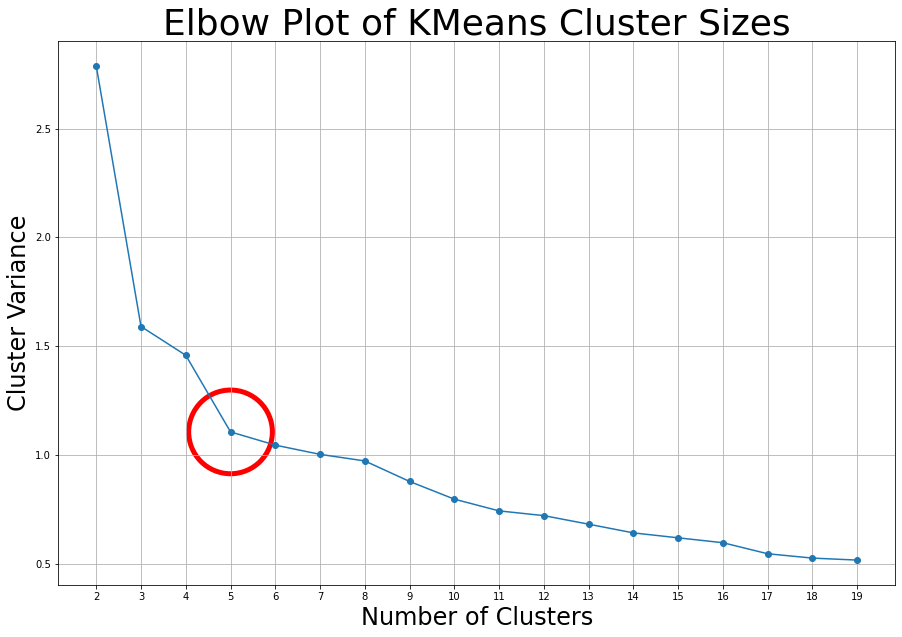

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(list(cluster_variances.keys()), list(cluster_variances.values()), '-o')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

ax.set_xlabel('Number of Clusters', fontsize=24)
ax.set_ylabel('Cluster Variance', fontsize=24)
ax.set_title('Elbow Plot of KMeans Cluster Sizes', fontsize=36)
plt.grid()

circ = ScaledCircle(ax, 5, cluster_variances[5])
ax.add_patch(circ)

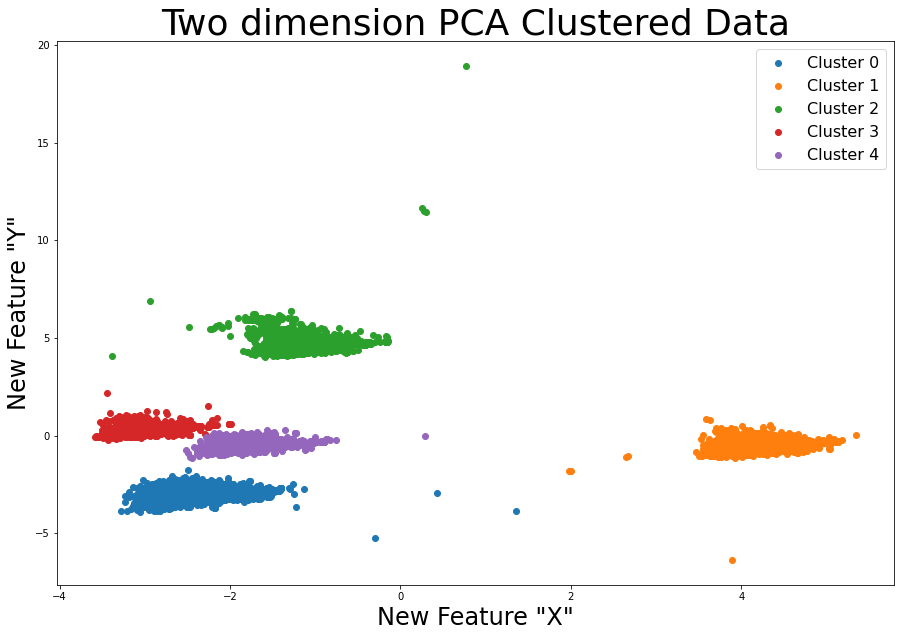

In [45]:
kmeans_model = KMeans(n_clusters=5)
kmeans_model.fit(final_2d)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

gb = final_2d.groupby(kmeans_model.labels_)
for group, data in gb:
    plt.scatter(data.X, data.Y)
    
ax.set_title('Two dimension PCA Clustered Data', fontsize=36)
ax.set_xlabel('New Feature "X"', fontsize=24)
ax.set_ylabel('New Feature "Y"', fontsize=24)

ax.legend([f'Cluster {n}' for n in range(11)], fontsize=16)

In [46]:
cluster_gb = final.groupby(kmeans_model.labels_)
# cluster_0 = final.loc[cluster_gb.groups[0]]

In [47]:
cluster_gb.agg('mean')

,latitude,longitude,stars,ethnic_food,food_trucks,specialty_food,imported_food,desserts,ice_cream_&_frozen_yogurt,grocery,middle_eastern,hotels_&_travel,beer,wine_&_spirits,food_delivery_services,donuts,juice_bars_&_smoothies,coffee_&_tea,bakeries,fast_food,mexican,vietnamese,soup,burgers,american_(traditional),chicken_wings,american_(new),hot_dogs,chinese,bars,arts_&_entertainment,nightlife,music_venues,cafes,shopping,local_flavor,flowers_&_gifts,florists,pizza,lounges,breakfast_&_brunch,salad,beauty_&_spas,barbers,thai,sandwiches,pubs,gastropubs,fish_&_chips,seafood,street_vendors,cajun/creole,italian,dive_bars,comfort_food,filipino,tex-mex,health_markets,vitamins_&_supplements,health_&_medical,active_life,venues_&_event_spaces,event_planning_&_services,party_&_event_planning,education,caterers,diners,sushi_bars,cosmetics_&_beauty_supply,convenience_stores,photography_stores_&_services,drugstores,barbeque,southern,buffets,asian_fusion,japanese,vegetarian,ramen,vegan,chicken_shop,candy_stores,automotive,gas_stations,food_stands,fitness_&_instruction,barre_classes,mediterranean,halal,cocktail_bars,shaved_ice,bubble_tea,delis,indian,adult_entertainment,custom_cakes,coffee_roasteries,beer_bar,tapas_bars,tapas/small_plates,arcades,wine_bars,fruits_&_veggies,discount_store,gluten-free,sports_bars,hookah_bars,soul_food,wraps,home_&_garden,do-it-yourself_food,gelato,tacos,greek,korean,french,steakhouses,caribbean,hair_salons,department_stores,fashion,casinos,breweries,local_services,bagels,hair_stylists,meat_shops,farmers_market,noodles,hawaiian,tobacco_shops,men's_hair_salons,creperies,wineries,home_services,professional_services,hotels,international_grocery,gift_shops,dance_clubs,car_wash,acai_bowls,tea_rooms,cupcakes,cheesesteaks,pakistani,pool_halls,karaoke,latin_american,chocolatiers_&_shops,gay_bars,electronics,poke,restaurantsattire,restaurantstakeout,businessacceptscreditcards,noiselevel,restaurantsreservations,restaurantsgoodforgroups,restaurantspricerange2,hastv,alcohol,restaurantsdelivery,costindex,costrank,grocerycost,housingcost,utilitiescost,transportationcost,misccost,health_spending_per_capita,household_income,population,murder_per_capita,violent_per_capita,rape_per_capita,robbery_per_capita,assault_per_capita,murder_per_capita_change,violent_per_capita_change,rape_per_capita_change,robbery_per_capita_change,assault_per_capita_change
0,38.479411,-81.273848,3.463072,0.010271,0.014528,0.060409,0.003311,0.039395,0.038111,0.052706,0.008244,0.007703,0.038516,0.038516,0.009933,0.013447,0.018650,0.078722,0.043246,0.118792,0.055612,0.006892,0.014190,0.091087,0.138996,0.051355,0.096358,0.012095,0.042841,0.168660,0.024326,0.173728,0.009866,0.024799,0.050409,0.007703,0.010812,0.004122,0.099196,0.015812,0.070816,0.052571,0.033921,0.025475,0.010136,0.125684,0.028853,0.006690,0.002568,0.037435,0.004325,0.004527,0.055679,0.010812,0.011622,0.000338,0.015204,0.010203,0.002297,0.006217,0.010676,0.011285,0.052639,0.003987,0.002703,0.036624,0.022704,0.021488,0.007433,0.025677,0.003446,0.021826,0.024799,0.016488,0.009528,0.017907,0.022772,0.011285,0.001960,0.008244,0.010474,0.004189,0.014123,0.012568,0.004189,0.003716,0.002770,0.017298,0.003379,0.018109,0.002162,0.002703,0.037638,0.010001,0.001487,0.005000,0.002230,0.011960,0.004189,0.006622,0.002500,0.022434,0.007636,0.006284,0.008649,0.036759,0.003311,0.008447,0.005473,0.003581,0.002095,0.001892,0.010947,0.012433,0.003041,0.003784,0.023042,0.006217,0.015744,0.006149,0.007636,0.000135,0.011082,0.003311,0.010541,0.005811,0.008987,0.006284,0.003649,0.001351,0.002500,0.006960,0.001824,0.003108,0.001757,0.001149,0.002973,0.002230,0.003041,0.004662,0.000946,0.002433,0.001960,0.008244,0.005946,0.001892,0.002297,0.002635,0.010541,0.005676,0.001622,0.003649,0.001487,0.018244,0.930468,0.982904,0.971214,0.435165,0.737955,1.799345,0.466383,0.979458,0.236908,92.777397,18.347861,97.909913,78.170755,95.061430,94.928259,103.116420,8028.478884,53335.250963,9.012256e+06,0.000030,0.003141,0.000388,0.0006

cluster 0: juice bars and smoothies  
cluster 1: bars, nightlife, pizza  
cluster 2: juice bars and smoothies, lounges  
cluster 3: deserts + icecream&frozenyoghurt+bakeries    
cluster 4: ethnic food + specialty_food + imported food, beauty spas, barbers, cosmetics and stores.  

We should be able to add cluster ID as a one-hot-encoded feature to improve our model performance.

# Supervised Learning + Clustering Feature

In [212]:
x_cols = [col for col in final.columns if col != 'stars']
X_train, X_test, y_train, y_test = train_test_split(final[x_cols], final['stars'])

final_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(final_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(final_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [49]:
kmeans_model = KMeans(n_clusters=5)
kmeans_model.fit(X_train_scaled)

cluster_dummies = pd.get_dummies(kmeans_model.labels_)
cluster_dummies.columns = [f'cluster_{cluster}' for cluster in cluster_dummies.columns]
cluster_dummies.index = X_train.index

X_train_scaled = X_train_scaled.join(cluster_dummies)

cluster_dummies_test = pd.get_dummies(kmeans_model.predict(X_test_scaled))
cluster_dummies_test.columns = [f'cluster_{cluster}' for cluster in cluster_dummies_test.columns]
cluster_dummies_test.index = X_test.index

X_test_scaled = X_test_scaled.join(cluster_dummies_test)

## Gradient Boost Regressor with Cross Validation

In [50]:
# grad_boost = GradientBoostingRegressor()
# gb_params = {'n_estimators': [50, 100, 500],
#           'max_depth': [3, 5, 7],
#           'min_samples_split': [2, 4, 6]}


# grid_cv = GridSearchCV(estimator=grad_boost, 
#                        param_grid=gb_params,
#                        n_jobs=16)

# grid_cv.fit(X_train_scaled, y_train)

Grid search CV found these to be the best hyperparameters:  
{'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 500}

In [51]:
grad_boost = GradientBoostingRegressor(max_depth=5, min_samples_split=6, n_estimators=500)
grad_boost.fit(X_train_scaled, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [52]:
gb_predict = grad_boost.predict(X_test_scaled)

gb_mae = mean_absolute_error(y_test, gb_predict)
gb_mse = mean_squared_error(y_test, gb_predict)

print(f'Gradient Boost MAE: {gb_mae}')
print(f'Gradient Boost MSE: {gb_mse}')

Gradient Boost MAE: 0.5632164367700434
Gradient Boost MSE: 0.5122556189171737


## Random Forest Regressor with Cross Validation

In [53]:
# random_forest = RandomForestRegressor()
# rf_params = {'n_estimators': [50, 100, 500],
#           'max_depth': [None, 10, 50, 500],
#           'min_samples_split': [2, 4, 6],
#           'min_samples_leaf': [1, 5, 8]}


# grid_rf = GridSearchCV(estimator=random_forest, 
#                        param_grid=params,
#                        n_jobs=16)

# grid_rf.fit(X_train_scaled, y_train)

Grid search CV found these to be the best hyperparameters:  
{'max_depth': 7, 'min_samples_split': 6, 'n_estimators': 500}

In [54]:
random_forest = RandomForestRegressor(max_depth=7, min_samples_split=6, n_estimators=500)
random_forest.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [55]:
rf_predict = random_forest.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test, rf_predict)
rf_mse = mean_squared_error(y_test, rf_predict)

print(f'Random Forest MAE: {rf_mae}')
print(f'Random Forest MSE: {rf_mse}')

Random Forest MAE: 0.6091566638724566
Random Forest MSE: 0.5784065124006182


## SVM Regressor with Cross Validation

In [56]:
# svm = SVR()
# svm_params = {'C': [0.5, 1, 2],
#               'epsilon': [0.01, 0.1, 1, 10]}


# svm_cv = GridSearchCV(estimator=svm, 
#                       param_grid=svm_params,
#                       n_jobs=16)

# svm_cv.fit(X_train_scaled, y_train)

Grid search CV found these to be the best hyperparameters:  
{'C': 0.5, 'epsilon': 0.1}

In [57]:
svm = SVR(C=0.5, epsilon=0.1)
svm.fit(X_train_scaled, y_train)

SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [58]:
svm_predict = svm.predict(X_test_scaled)

svm_mae = mean_absolute_error(y_test, svm_predict)
svm_mse = mean_squared_error(y_test, svm_predict)

print(f'Random Forest MAE: {svm_mae}')
print(f'Random Forest MSE: {svm_mse}')

Random Forest MAE: 0.5603494039281383
Random Forest MSE: 0.5203688430435243


This takes a long time to train, even when just training a single model!

# Dummy Restaurant Test

In [68]:
# import pickle
# with open('grad_boost_model.p', 'wb') as fout:
#     pickle.dump(grad_boost, fout)

In [59]:
latitude = '44.4759'
longitude = '73.2121'

categories = [('italian',),
              ('pizza',),
              ('fast_food',),
              ('barbeque',),]

Try with beer = 1 and beer = 0.

In [60]:
lat_range = np.linspace(25, 49, num=200)
lon_range = np.linspace(-124, -67, num=200)
lat, lon = zip(*product(lat_range, lon_range))

In [113]:
def create_restaurant_heatmap(base_index, title):
    food_grid = pd.DataFrame([final.loc[base_index]] * len(lat)).reset_index()
    food_grid['latitude'] = lat
    food_grid['longitude'] = lon

    food_X = food_grid[x_cols]
    food_scaled = pd.DataFrame(final_scaler.fit_transform(food_X), columns=food_X.columns, index=food_X.index)

    food_clusters = pd.get_dummies(kmeans_model.predict(food_scaled))
    food_clusters.columns = [f'cluster_{cluster}' for cluster in food_clusters.columns]
    food_clusters.index = food_scaled.index
    for n in range(5):
        colname = f'cluster_{n}'
        if colname not in food_clusters:
            food_clusters[colname] = 0
    food_clusters = food_clusters[food_clusters.columns.sort_values()]

    food_scaled = food_scaled.join(food_clusters)

    food_stars = grad_boost.predict(food_scaled)

    food_results = food_grid[['latitude', 'longitude']].copy()
    food_results['stars'] = food_stars

    fig, ax = plt.subplots(1, 1, figsize=(15,10))

    sns.heatmap(food_results.pivot(index='longitude', columns='latitude', values='stars'), cmap='RdYlGn')

    ax.set_title(f"Predicted {title} Restaurant Ratingn by Latitude, Longintude", fontsize=24)
    ax.set_xlabel('Latitude', fontsize=24)
    ax.set_ylabel('Longitude', fontsize=24)

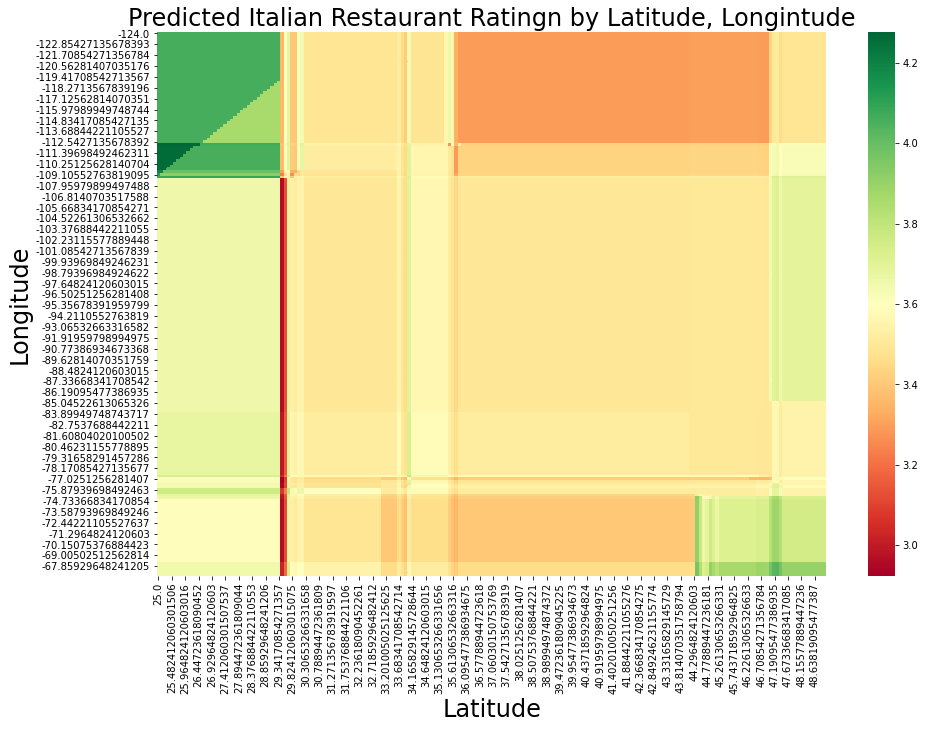

In [114]:
# Italian
create_restaurant_heatmap('0y6alZmSLnPzmG5_kP5Quw', 'Italian')

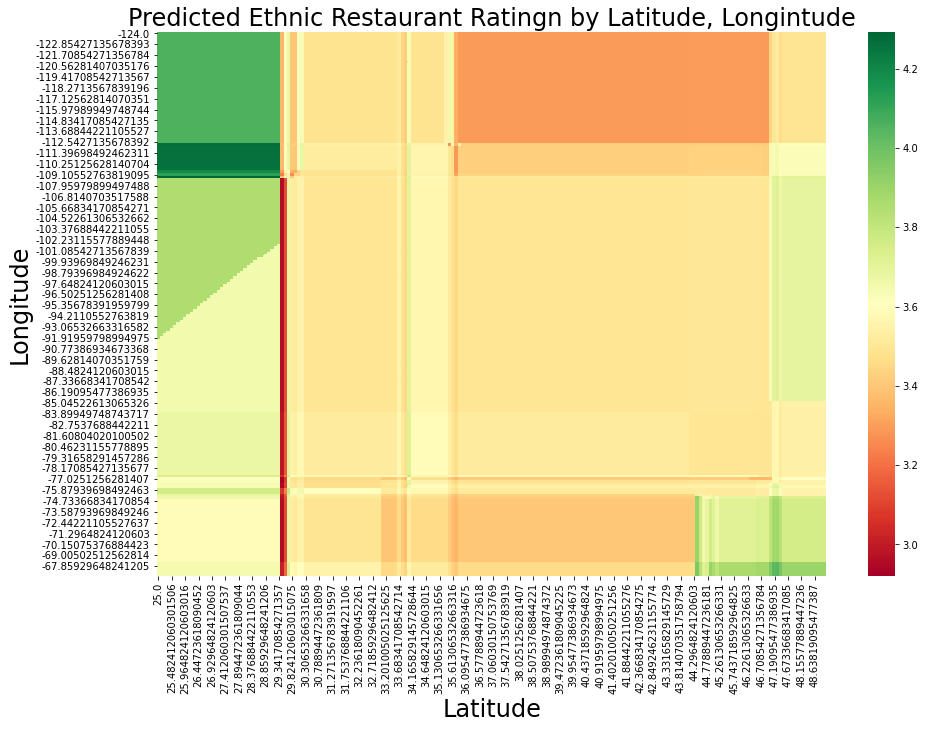

In [115]:
# Ethnic Food
create_restaurant_heatmap('pQeaRpvuhoEqudo3uymHIQ', 'Ethnic')

### Decision Tree

In [166]:
# dec_tree = DecisionTreeRegressor()

# dec_tree_params = {'min_samples_split': [2, 20, 200],
#                    'min_samples_leaf': [1, 10, 100],
#                    'max_features': [None, 10, 50]}

# dec_tree_grid = GridSearchCV(estimator=dec_tree,
#                              param_grid=dec_tree_params).fit(final[x_cols], final['stars'])

In [167]:
print(f'Decision Tree grid best params: {dec_tree_grid.best_params_}')

Decision Tree grid best params: {'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 200}


In [168]:
dec_tree = DecisionTreeRegressor(max_features=None, min_samples_leaf=10, min_samples_split=200)

dec_tree.fit(final[x_cols], final['stars'])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=200,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [169]:
feature_importance = sorted(x_cols, key=lambda colname: dec_tree.feature_importances_[x_cols.index(colname)], reverse=True)

In [178]:
feature_importance[:5]

['fast_food', 'convenience_stores', 'longitude', 'latitude', 'coffee_&_tea']

In [179]:
dec_tree.get_depth()

68

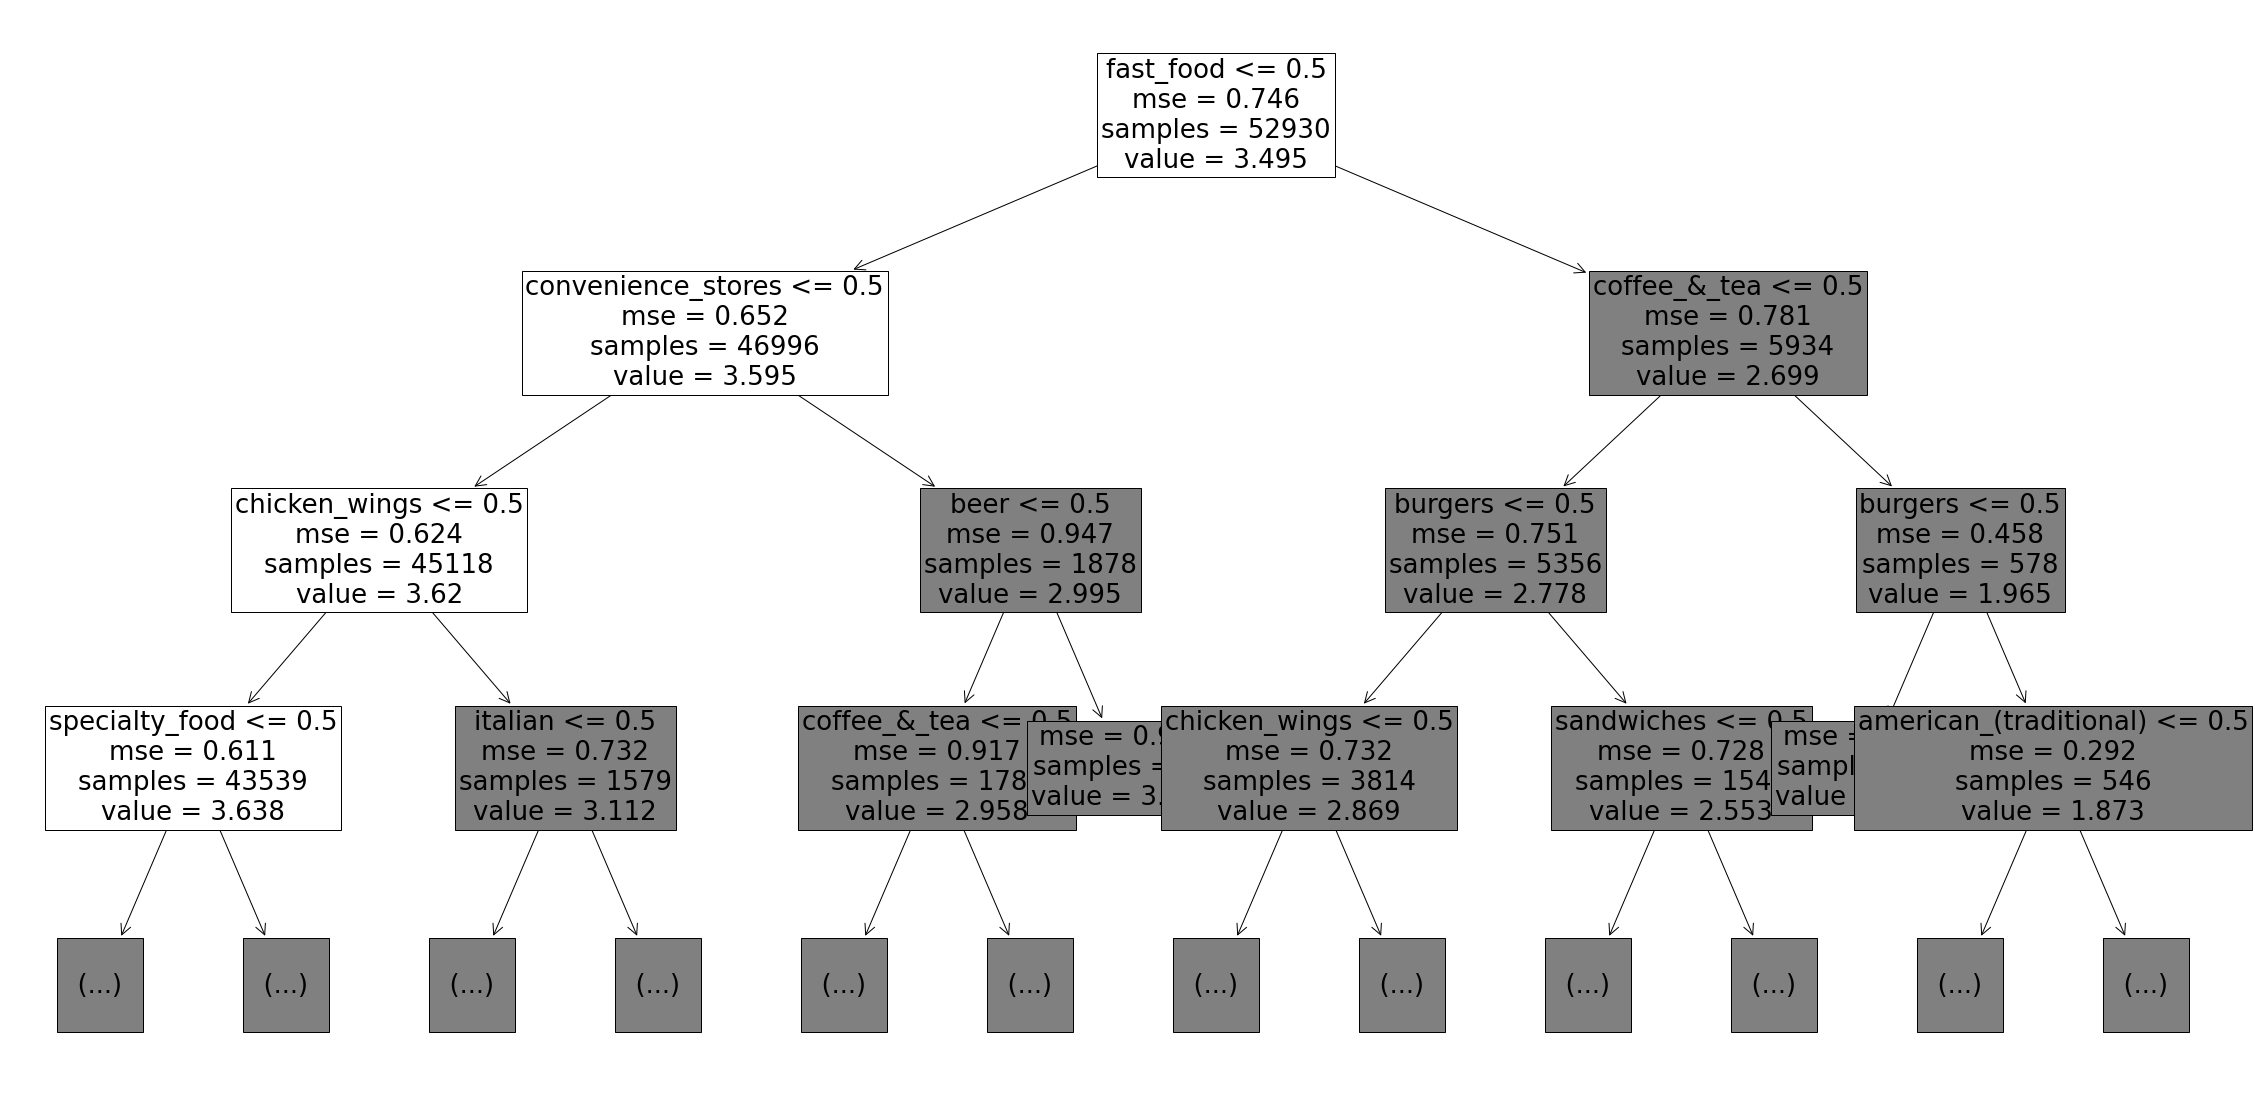

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(40,20))
plot_tree(dec_tree, max_depth=3, feature_names=x_cols, fontsize=26);

### Vermont Restaurants

In [247]:
food_categories = ['ethnic_food',
                   'food_trucks',
                   'specialty_food',
                   'desserts',
                   'ice_cream_&_frozen_yogurt',
                   'middle_eastern',
                   'wine_&_spirits',
                   'fast_food',
                   'mexican',
                   'vietnamese',
                   'soup',
                   'burgers',
                   'american_(traditional)',
                   'pizza',
                   'seafood',
                   'italian',
                   'tacos',
                   'drugstores',
                   'barbeque',
                   'southern',
                   'buffets',
                   'asian_fusion',
                   'japanese',
                   'vegetarian']

(3.5, 5.5)

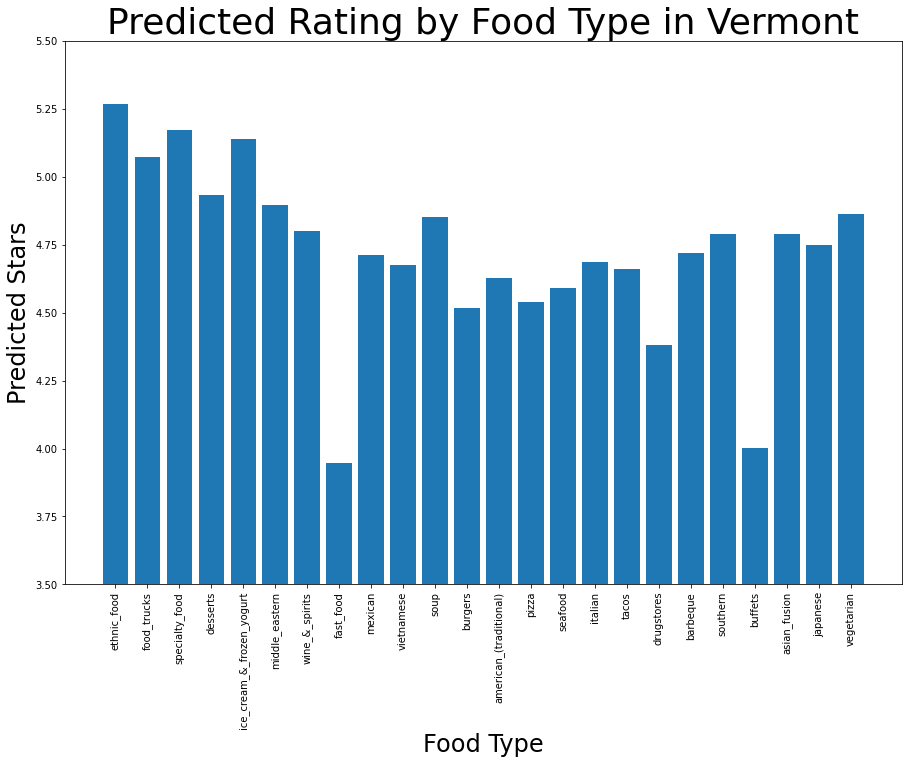

In [248]:
vt_base = final[x_cols].loc['tJRDll5yqpZwehenzE2cSg'].copy()
for col in yelp_final.columns:
    if col not in ('state', 'latitude', 'longitude', 'stars'):
        vt_base[col] = 0

vt_data = pd.DataFrame([vt_base] * len(food_categories)).reset_index(drop=True)
for row, food in enumerate(food_categories):
    vt_data.loc[row, food] = 1
    
vt_scaled = pd.DataFrame(final_scaler.transform(vt_data), index=vt_data.index)
    
vt_clusters = pd.get_dummies(kmeans_model.predict(vt_scaled))
vt_clusters.columns = [f'cluster_{cluster}' for cluster in vt_clusters.columns]
vt_clusters.index = vt_data.index
for n in range(5):
    colname = f'cluster_{n}'
    if colname not in vt_clusters:
        vt_clusters[colname] = 0
vt_clusters = vt_clusters[vt_clusters.columns.sort_values()]

vt_scaled = vt_scaled.join(vt_clusters)
    
vt_stars = grad_boost.predict(vt_scaled)

fig, ax = plt.subplots(1, 1, figsize=(15,10))
plt.bar(x=food_categories, height=vt_stars)
plt.xticks(rotation=90);

ax.set_title('Predicted Rating by Food Type in Vermont', fontsize=36)
ax.set_xlabel('Food Type', fontsize=24)
ax.set_ylabel('Predicted Stars', fontsize=24)

ax.set_ylim(3.5, 5.5)

(2.5, 4.5)

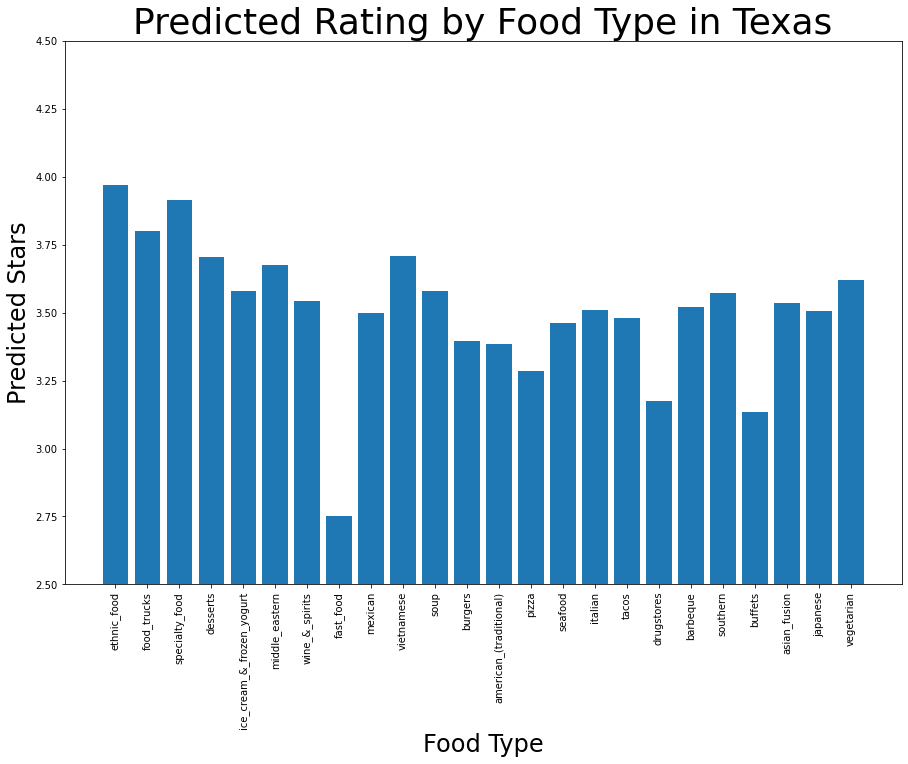

In [251]:
tx_base = final[x_cols].loc['wr6z01f4jcGQkRQMSw7nLg'].copy()
for col in yelp_final.columns:
    if col not in ('state', 'latitude', 'longitude', 'stars'):
        tx_base[col] = 0

tx_data = pd.DataFrame([tx_base] * len(food_categories)).reset_index(drop=True)
for row, food in enumerate(food_categories):
    tx_data.loc[row, food] = 1
    
tx_scaled = pd.DataFrame(final_scaler.transform(tx_data), index=tx_data.index)
    
tx_clusters = pd.get_dummies(kmeans_model.predict(tx_scaled))
tx_clusters.columns = [f'cluster_{cluster}' for cluster in tx_clusters.columns]
tx_clusters.index = tx_data.index
for n in range(5):
    colname = f'cluster_{n}'
    if colname not in tx_clusters:
        tx_clusters[colname] = 0
tx_clusters = tx_clusters[tx_clusters.columns.sort_values()]

tx_scaled = tx_scaled.join(tx_clusters)
    
tx_stars = grad_boost.predict(tx_scaled)

fig, ax = plt.subplots(1, 1, figsize=(15,10))
plt.bar(x=food_categories, height=tx_stars)
plt.xticks(rotation=90);

ax.set_title('Predicted Rating by Food Type in Texas', fontsize=36)
ax.set_xlabel('Food Type', fontsize=24)
ax.set_ylabel('Predicted Stars', fontsize=24)

ax.set_ylim(2.5, 4.5)


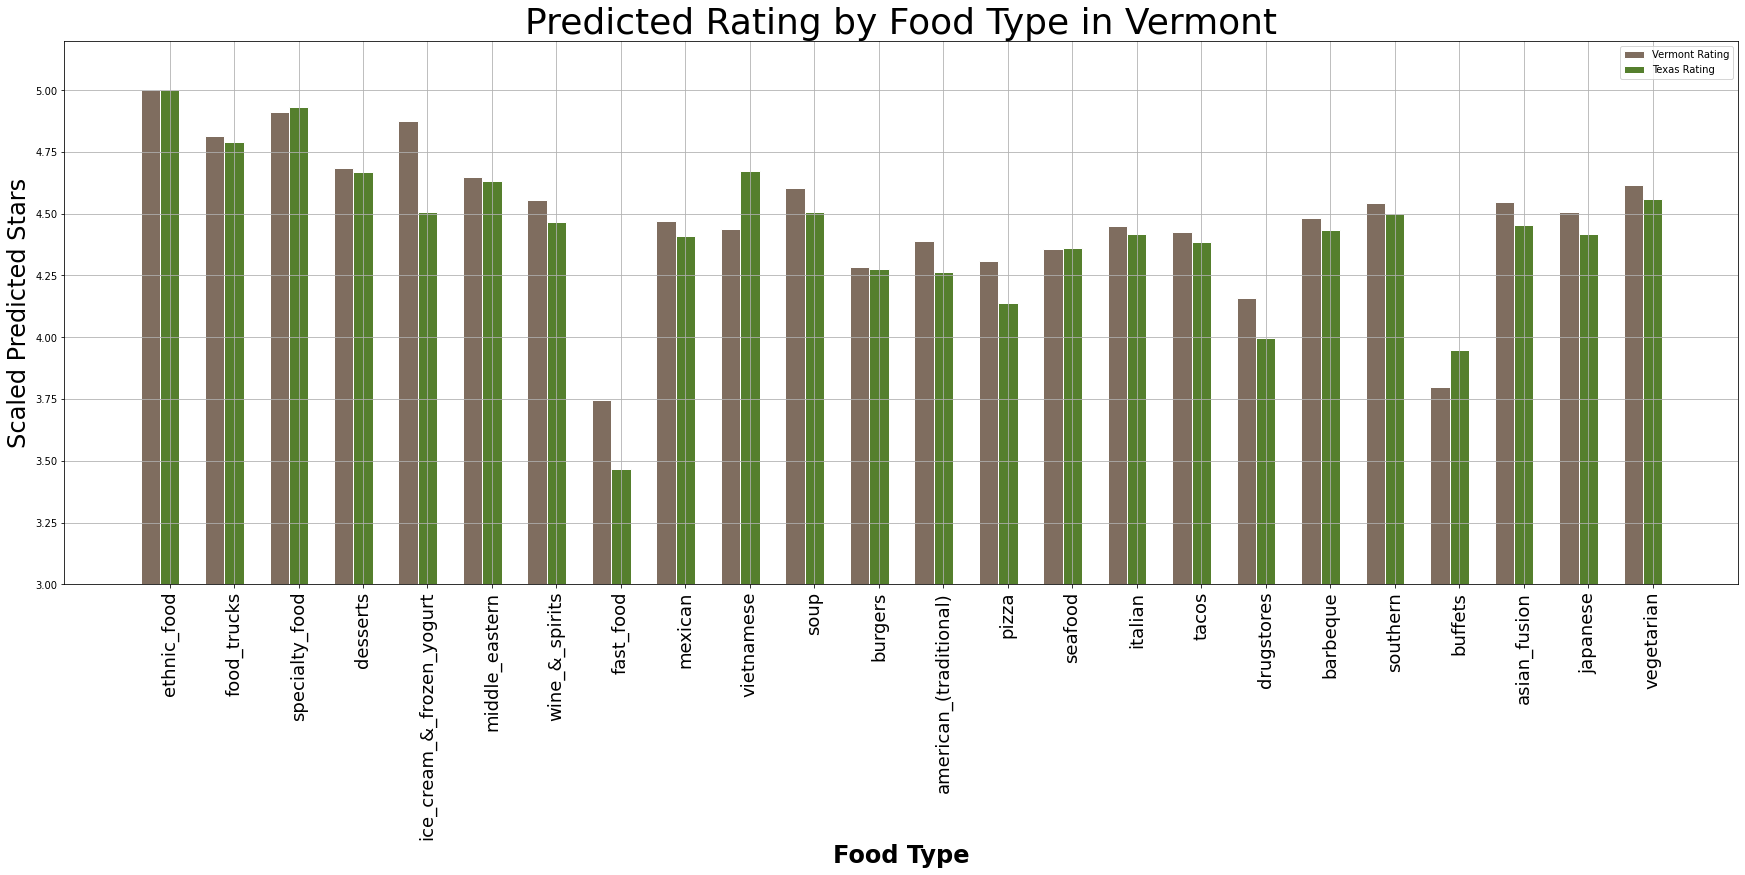

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.set_ylim(3, 5.2)
barWidth = 0.3
bars1 = vt_stars / max(vt_stars) * 5
bars2 = tx_stars / max(tx_stars) * 5
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Vermont Rating')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Texas Rating')
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], food_categories, rotation=90, fontsize=18)
plt.legend()

ax = plt.gca()
ax.set_title('Predicted Rating by Food Type in Vermont', fontsize=36)
ax.set_xlabel('Food Type', fontsize=24)
ax.set_ylabel('Scaled Predicted Stars', fontsize=24)
ax.grid()